<a href="https://colab.research.google.com/github/jeffersonlicet/litoral-audio-classification/blob/master/897IA_Litoral2019_Jefferson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bienvenido 🐮
**IA en Ganadería de Precisión**

---



Este colab te permite recrear (*casi exactamente*) cómo logré alcanzar el top 5 en el leaderboard público del concurso.


Digo casi exactamente ya que no logré encontrar la forma de fijar los números randoms en colab. Sin embargo la idea es la misma.

# ⚪ **1** Vamos a importar las librerías necesarias

In [0]:
import os
import csv
import shutil
import librosa
import numpy as np
import pandas as pd
import zipfile as zf
import librosa.display
from pathlib import Path
from google.colab import files as filescolab

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Input
from tensorflow.keras.regularizers import l2

BASE_PATH = Path('/')
DATA_PATH = BASE_PATH / 'data_competition_2'
DATA_ZIP_FILE = DATA_PATH / 'data.zip'
AUDIO_PATH = DATA_PATH / 'data'

LABELS_CSV_FILE = DATA_PATH / 'train_labels.csv'
BOTTLENECKS_PATH = DATA_PATH / 'bottlenecks'
MODELS_PATH = DATA_PATH / 'models'
SOLUTION_PATH = DATA_PATH / 'solution.csv'

# ⚪ **2** Descargamos y preparamos los datos de la competencia

In [0]:
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
os.chdir(DATA_PATH)

if not os.path.exists(BOTTLENECKS_PATH):
    os.makedirs(BOTTLENECKS_PATH)

if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

In [0]:
!wget --quiet --no-clobber https://www.dropbox.com/s/qoyduoa5prupyzr/test_files.csv
!wget --quiet --no-clobber https://www.dropbox.com/s/z1cwznln0gfpw32/train_labels.csv
!wget --no-clobber https://www.dropbox.com/s/d12x5vknrk9yek1/data.zip

--2019-11-22 14:09:24--  https://www.dropbox.com/s/d12x5vknrk9yek1/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/d12x5vknrk9yek1/data.zip [following]
--2019-11-22 14:09:24--  https://www.dropbox.com/s/raw/d12x5vknrk9yek1/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd512c234f5260f667478c43bba.dl.dropboxusercontent.com/cd/0/inline/As3-qOmdD--lqUorblAn4RNmCAMNRlIHG1v35MlTGvIsnm290TtyU034IsOHancYeTV8E_p2KqP48PX_J707bZaltJLEoUbMnMMzOKJKCrzVL5_hOgjyLHlR1bD0qCFXylc/file# [following]
--2019-11-22 14:09:24--  https://ucd512c234f5260f667478c43bba.dl.dropboxusercontent.com/cd/0/inline/As3-qOmdD--lqUorblAn4RNmCAMNRlIHG1v35MlTGvIsnm290TtyU034IsOHancYeTV8E_p2KqP48PX_J707bZaltJLEoUbMnMMzOKJKCrzVL5_hOgjyLHlR1bD0

In [0]:
if not os.path.exists(AUDIO_PATH) and os.path.isfile('data.zip'):
    with zf.ZipFile(DATA_ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall('.')

# ⚪ **3** Análisis y exploración del conjunto de datos

Cargamos el CSV usando Pandas e imprimimos un subconjunto de los datos


In [0]:
data = pd.read_csv(LABELS_CSV_FILE, dtype=str)
data.head()

,filename,pasture,height,label
0,0004,alfalfa,tall,2
1,0009,alfalfa,tall,2
2,0010,alfalfa,tall,1
3,0011,alfalfa,tall,2
4,0013,alfalfa,tall,2


Sólo utilizaremos filename y label.
Demos un vistazo al dataset y a las diferentes categorías:

In [0]:
print('Hay un total de {} categorias en el dataset'.format(len(np.unique(data.label))))
print('Y un total de {} entradas'.format(data.shape[0]))

Hay un total de 3 categorias en el dataset
Y un total de 1532 entradas


Veamos la distribución por categorías

In [0]:
data.groupby('label').size()

label
0    255
1    827
2    450
dtype: int64

El dataset claramente no está balanceado, tomaremos esto en cuenta en el futuro. 

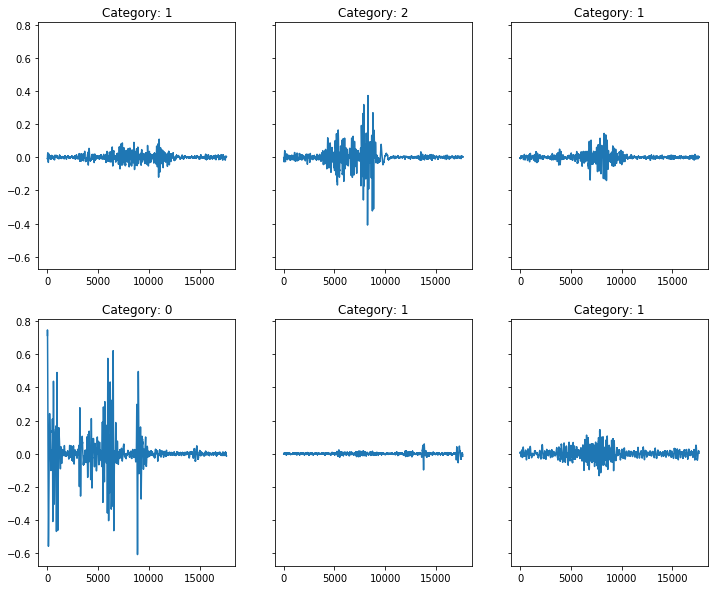

In [0]:
# Obtenemos un sampleo de los archivos
sample = data.sample(6, random_state=10)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,10), sharey=True)

for i in range(6):
  entry = sample.iloc[i]
  # Ploteamos los archivos de audio
  y, sr = librosa.load(AUDIO_PATH / (entry.filename + '.wav'), sr=None)
  axes[i % 2, i % 3].set_title('Category: ' + entry.label)
  axes[i % 2, i % 3].plot(y)


Segun los datos de la competencia todos los sonidos deberían respetar una duracion de: 0.8 segundos

Se puede observar en las gráficas de **Señal Sonora** que las señales interesantes están centradas, es decir, a pesar de la duración de 0.8s, el archivo de audio puede ser aún más reducido. Por otro lado explorando los datos pude notar que algunos archivos tienen sonidos posiblemente de la cámara.
Por ejemplo: el archivo **0032.wav**

In [0]:
y, sr = librosa.load(AUDIO_PATH / '0032.wav', sr=None)
Audio(data=y, rate=sr)

Este sonido se encuentra en varios archivos:


*   0032.wav
*   0023.wav
*   0421.wav

... y otros más


Veamos como luce el Spectogram del primer archivo

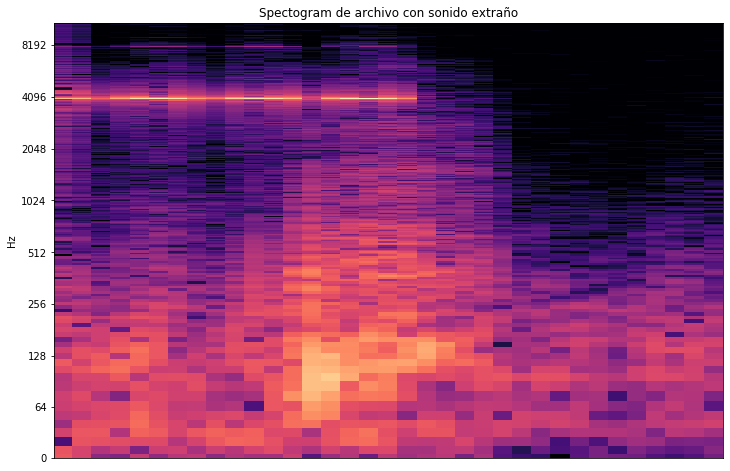

In [0]:
D = librosa.stft(y)
rp = np.max(np.abs(D))
plt.figure(figsize=(12, 8))
plt.title('Spectogram de archivo con sonido extraño')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp), y_axis='log')

Se puede notar que las lineas que describen este sonido extraño son bastante horizontales, esto es un indicio para saber que es un sonido harmónico según la lectura: 

**HARMONIC/PERCUSSIVE SEPARATION USING MEDIAN FILTERING.** (http://dafx10.iem.at/papers/DerryFitzGerald_DAFx10_P15.pdf)

Podemos separar este sonido harmónico de los sonidos percusivos de la siguiente forma:


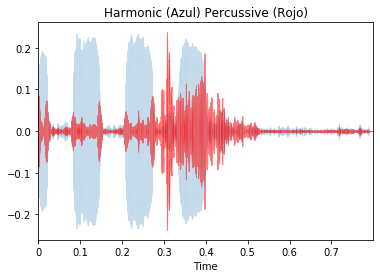

In [0]:
y_harm, y_perc = librosa.effects.hpss(y, margin=1)
librosa.display.waveplot(y_harm, sr=sr, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic (Azul) Percussive (Rojo)')
plt.show()

Efectivamente logramos detectar estos sonidos harmónicos y ahora podemos separarlos del archivo como parte del preprocesamiento, veamos más ejemplos:

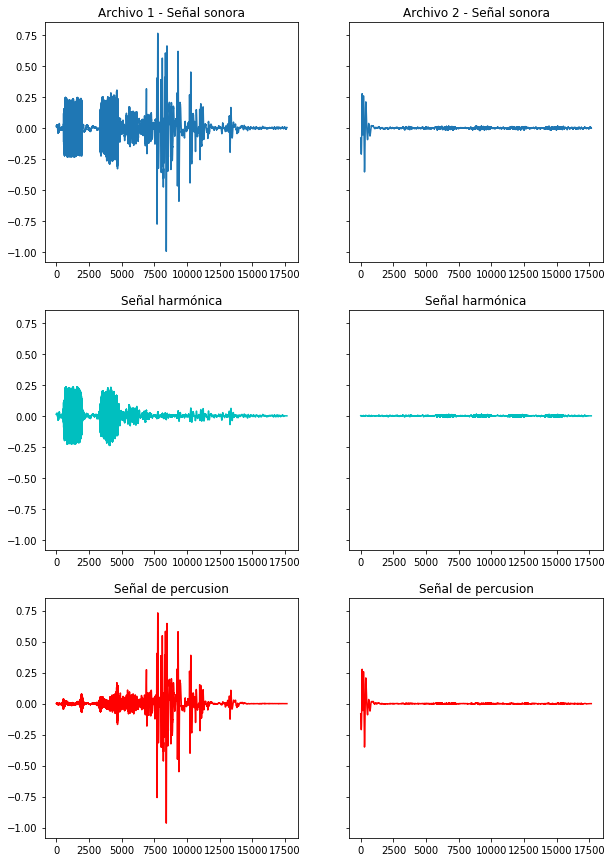

In [0]:
y, sr = librosa.load(AUDIO_PATH / '0023.wav', sr=None, mono=True, duration=0.8)
y2, sr2 = librosa.load(AUDIO_PATH / '0421.wav', sr=None, mono=True,  duration=0.8)

y_harm, y_perc = librosa.effects.hpss(y)
y2_harm, y2_perc = librosa.effects.hpss(y2)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15), sharey=True)

axes[0, 0].set_title('Archivo 1 - Señal sonora')
axes[0, 0].plot(y)

axes[1, 0].set_title('Señal harmónica')
axes[1, 0].plot(y_harm, color='c')

axes[2, 0].set_title('Señal de percusion')
axes[2, 0].plot(y_perc, color='r')

axes[0, 1].set_title('Archivo 2 - Señal sonora')
axes[0, 1].plot(y2)

axes[1, 1].set_title('Señal harmónica')
axes[1, 1].plot(y2_harm, color='c')

axes[2, 1].set_title('Señal de percusion')
axes[2, 1].plot(y2_perc, color='r')

**Harmónico semi aislado:**

In [0]:
Audio(data=y_harm, rate=sr)

**Percusión semi aislada:**

In [0]:
Audio(data=y_perc, rate=sr)

# ⚪ **4** Preprocesamos todos los datos

**MFCC**

La representación elegida para los sonidos fueron los Coeﬁcientes Cepstrales en las Frecuencias de Mel

Lucen de la siguiente forma:

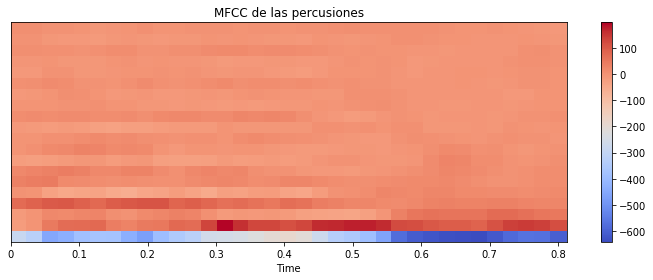

In [0]:
y, sr = librosa.load(AUDIO_PATH / '0032.wav', sr=None)
y_harm, y_perc = librosa.effects.hpss(y)

mfccs = librosa.feature.mfcc(y_perc, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC de las percusiones')
plt.tight_layout()
plt.show()

Código para preprocesar los archivos de audio

In [0]:
import sklearn
import pandas as pd
from tqdm import tqdm

max_ = 0

# TODO: run on batch
def create_spectrogram(filename, name, max_len=35):
  global max_
  y, sample_rate = librosa.load(filename, mono=True, sr=None, duration=0.8)

  # Remove harmonics ->
  y_harm, y = librosa.effects.hpss(y)

  # Generate mfcc ->
  mfcc = librosa.feature.mfcc(y, sr=sample_rate, n_mfcc=20)

  if mfcc.shape[1] > max_:
    max_ = mfcc.shape[1]

  if (max_len > mfcc.shape[1]):
      pad_width = max_len - mfcc.shape[1]
      mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
  else:
    mfcc = mfcc[:, :max_len]

  return mfcc

def preprocess_train_data():
  global max_
  max_ = 0
  data = pd.read_csv(LABELS_CSV_FILE, dtype=str)

  labels = []
  features = []

  for i in tqdm(range(data.shape[0])):
    label = data.iloc[i].label
    filepath = data.iloc[i].filename
    labels.append(int(label))
    features.append(create_spectrogram(AUDIO_PATH / (filepath+'.wav'), filepath))

  np.save(BOTTLENECKS_PATH / 'mfcc.npy', features)
  np.save(BOTTLENECKS_PATH / 'labels.npy', labels)
  print('Labels and mfcc array saved')

def preprocess_test_data(audio_path, csv_path):
  global max_
  max_ = 0
  data = pd.read_csv(csv_path, dtype=str)
  features = []

  for i in tqdm(range(data.shape[0])):
    filepath = data.iloc[i].filename
    features.append(create_spectrogram(audio_path / (filepath+'.wav'), filepath))
  np.save(BOTTLENECKS_PATH / 'test.npy', features)
  print('\nTest mfcc array saved')


In [0]:
preprocess_train_data()

100%|██████████| 1532/1532 [04:41<00:00,  5.22it/s]

Labels and mfcc array saved


# ⚪ **5** Definición del modelo

Es importante aclarar en este punto que mi poca experiencia viene de clasificar imágenes y texto para otras competencias. 

Mi primer enfoque fue guardar las imagenes de los MFCC o Melspectrograms y utilizar Transfer Learning mediante modelos como VGG16, y así atacar el problema como si se tratara de clasificación de imágenes.

Sin embargo no obtuve buenos resultados, pero la arquitectura de mi modelo, que, sigue varios ejemplos de arquitecturas como VGG parece dar buenos resultados aplicada directamente sobre el mfcc.

**Antes de entrenar**
* El dataset es dividido 85-15 para training y validating data.
* Se computan los pesos por clases ya que el dataset no está balanceado para lograr un mejor BACC




In [0]:
x = np.load(BOTTLENECKS_PATH / 'mfcc.npy', allow_pickle=True)
y = np.load(BOTTLENECKS_PATH / 'labels.npy', allow_pickle=True)

print("Input shape: ")
print(x.shape)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)

# Reshape para agregar una dimension
x = x.reshape(x.shape[0], 20, 35, 1)

def generate_model(x_train, y_train, x_test, y_test, disabled=False, iteration=0):
  model = Sequential()
  print('Starting kfold iteration: ' + str(iteration))

  model.add(Input(shape=(x.shape[1], x.shape[2], x.shape[3])))
  
  # Bloque 1
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Dropout(0.35))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  # Bloque 2
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Dropout(0.35))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

 # Bloque 3
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Dropout(0.35))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  # Classification layer
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss=sparse_categorical_crossentropy,
                optimizer=Adam(lr=0.0001),
                metrics=['accuracy'])
  
  if disabled:
    return model, 0

  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
  mcp_save = tf.keras.callbacks.ModelCheckpoint(str(MODELS_PATH / (str(iteration) +'_model.hdf5')),
                                                save_best_only=True,
                                                monitor='val_loss',
                                                mode='min')

  model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    epochs=300,
    class_weight=class_weights,
    batch_size=32,
    verbose=2,
    callbacks=[es, mcp_save]
  )

  y_pred = model.predict(x_test, verbose=0)
  y_pred_max = np.argmax(y_pred, axis=1).tolist()

  print("Balanced Acc for: ")
  bacc = balanced_accuracy_score(y_test, y_pred_max)
  print ("########## Balanced Acc: %0.8f ##########" % bacc )

  return model, bacc

Input shape: 
(1532, 20, 35)


Mi modelo está basado en Deep Learning, consistiendo en 3 bloques de Convolutional Layers muy parecido a la arquitectura VGG:

Starting kfold iteration: 0


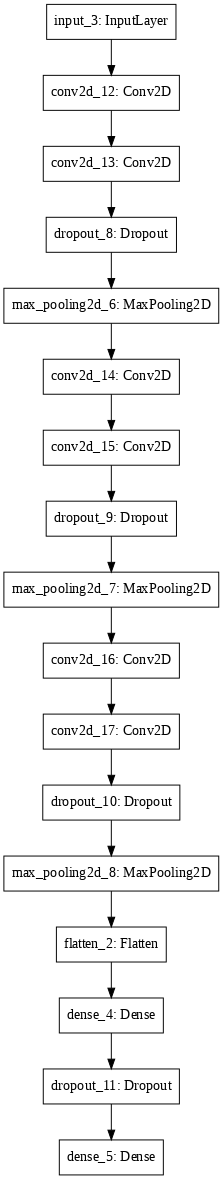

In [0]:
model, _ = generate_model([], [], [], [], disabled=True)
plot_model(model, dpi=70)

Los hyperparameters fueron encontrados utilizando random search.

Utilizamos Dropout en cada bloque y luego de las capas ocultas para evitar overfitting. El dataset es relativamente pequeño y muy susceptible overfitting  


# ⚪ **6** Entrenamiento

* Comenzamos el entrenamiento usando StratifiedKFold y separando 70% para entrenar (training, validating) y 30% testing.


* Hacemos **6** folds, 1/6 de los datos por fold son para validar en la iteración.


* Finalmente ensamblamos los modelos.


> Debido a que no pude fijar los numeros randoms utilicé Kfolds para obtener un resultado superior a modelos individuales.


**El procedimiento es el siguiente:**

Para cada Fold guardo los mejores modelos monitoreando su performance durante la fase de entrenamiento.

Luego, teniendo la lista de los mejores modelos, realizo la predicción entre todos, ensamblando el resultado final.



In [0]:
shutil.rmtree(MODELS_PATH)

if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

n_folds = 6
x, x_test, y, y_test = train_test_split(x, y, test_size=0.15, random_state=8, stratify=y)
kfold = StratifiedKFold(n_folds, True, 1)
scores, models = list(), list()
iteration = 0
for train_ix, test_ix in kfold.split(x, y):
	trainX, trainy = x[train_ix], y[train_ix]
	testX, testy = x[test_ix], y[test_ix]
	model, test_acc = generate_model(trainX, trainy, testX, testy, False, iteration)
	scores.append(test_acc)
	iteration = iteration + 1
 
print('Acc estimado %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Starting kfold iteration: 0
Train on 1083 samples, validate on 219 samples
Epoch 1/300
1083/1083 - 1s - loss: 1.9890 - acc: 0.4109 - val_loss: 1.0450 - val_acc: 0.5434
Epoch 2/300
1083/1083 - 1s - loss: 0.9969 - acc: 0.4977 - val_loss: 1.0143 - val_acc: 0.5479
Epoch 3/300
1083/1083 - 1s - loss: 0.9670 - acc: 0.4958 - val_loss: 0.9542 - val_acc: 0.6256
Epoch 4/300
1083/1083 - 1s - loss: 0.9190 - acc: 0.5300 - val_loss: 0.9257 - val_acc: 0.5342
Epoch 5/300
1083/1083 - 1s - loss: 0.9288 - acc: 0.5374 - val_loss: 0.9374 - val_acc: 0.6438
Epoch 6/300
1083/1083 - 1s - loss: 0.8814 - acc: 0.5614 - val_loss: 0.8554 - val_acc: 0.6530
Epoch 7/300
1083/1083 - 1s - loss: 0.8741 - acc: 0.5512 - val_loss: 0.8542 - val_acc: 0.6164
Epoch 8/300
1083/1083 - 1s - loss: 0.8448 - acc: 0.6066 - val_loss: 0.8190 - val_acc: 0.6621
Epoch 9/300
1083/1083 - 1s - loss: 0.8220 - acc: 0.6316 - val_loss: 0.7982 - val_acc: 0.6484
Epoch 10/300
1083/1083 - 1s - loss: 0.7998 - acc: 0.6353 - val_loss: 0.8199 - val_acc: 0

Ahora ponemos a prueba los mejores modelos con datos que nunca han visto:

In [0]:
def ensemble_pred(models, testX):
	yhats = [model.predict(testX) for model in models]
	yhats = np.array(yhats)
	summed = np.sum(yhats, axis=0)
	result = np.argmax(summed, axis=1)
	return result

def evaluate_n_models(models, n_models, testX, testy):
	subset = models[:n_models]
	yhat = ensemble_pred(subset, testX)
	return accuracy_score(testy, yhat)
 
single_scores, ensemble_scores = list(), list()

models_folder = os.listdir(MODELS_PATH)

for model_path in models_folder:
	models.append(tf.keras.models.load_model(MODELS_PATH / model_path))
	print('Model {} loaded'.format(model_path))

for i in range(1, n_folds+1):
	ensemble_score = evaluate_n_models(models, i, x_test, y_test)
	_, single_score = models[i-1].evaluate(x_test, y_test, verbose=0)
	print('> %d: single=%.3f, ensembled=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
 
print('Acc individual %.3f (%.3f)' % (np.mean(single_scores), np.std(single_scores)))
print('Acc assembled %.3f (%.3f)' % (np.mean(ensemble_scores), np.std(ensemble_scores)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model 3_model.hdf5 loaded
Model 0_model.hdf5 loaded
Model 4_model.hdf5 loaded
Model 1_model.hdf5 loaded
Model 5_model.hdf5 loaded
Model 2_model.hdf5 loaded
> 1: single=0.909, ensembled=0.909
> 2: single=0.887, ensembled=0.896
> 3: single=0.891, ensembled=0.891
> 4: single=0.891, ensembled=0.896
> 5: single=0.887, ensembled=0.896
> 6: single=0.887, ensembled=0.896
Acc individual 0.892 (0.008)
Acc assembled 0.897 (0.005)


El balanced acc del modelo que envié al concurso fue de tan solo **0.873**

Luego de correr el balanced Acc del modelo ensamblado es de **0.897** 🥳🥳

# ⚪ **7** Generando la solución y prediciendo otros archivos

Ahora generamos los bottlenecks/preprocesamos los archivos que se proveen para testear.

> Es posible indicar otro directorio y otro archivo csv aquí:

In [0]:
TEST_AUDIO_PATH = DATA_PATH / 'data'
TEST_CSV_FILE = DATA_PATH / 'test_files.csv'

preprocess_test_data(TEST_AUDIO_PATH, TEST_CSV_FILE)

100%|██████████| 1551/1551 [07:33<00:00,  3.16it/s]


Test mfcc array saved


Ahora podemos predecir sobre los archivos tests y descargar el csv:

In [0]:
data = pd.read_csv(TEST_CSV_FILE, dtype=str)
test_features = np.load(BOTTLENECKS_PATH / 'test.npy', allow_pickle=True)
test_features = test_features.reshape(test_features.shape[0], 20, 35, 1)

filenames = data.filename.to_numpy()

labels = []
files = []

for i in tqdm(range(data.shape[0])):
  filename = filenames[i]
  features = test_features[i]
  files.append(filename)
  labels.append(ensemble_pred(models, np.array([features]))[0])

with open(SOLUTION_PATH, mode='w') as file:
  test_writter = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for i in range(len(files)):
    test_writter.writerow([str(files[i]), str(labels[i])])
filescolab.download(SOLUTION_PATH)




100%|██████████| 1551/1551 [00:58<00:00, 26.47it/s]


# Gracias por leer 🐮
* Mi sitio web: http://jeffersonlicet.com/
* Mi github: https://github.com/jeffersonlicet

Puedes decargar la predicción aquí:
https://drive.google.com/file/d/1myorzA-8osrAL6zXE-APFc1yGuOSvJbF/view?usp=sharing
